In [2]:
from func_modules import ControllerGraph
import pandas as pd
import pickle
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
edges = pd.read_csv('./data/edges.csv')
controller = ControllerGraph(edges)
with open('./graphs.pickle', 'rb') as file:
    hero_graph, hero_comics_graph = pickle.load(file)

## Functionality 3: explaining and visualizing

For the third functionality we are asked to build a function which, given the bipartite graph with heroes and comics, returns the shortest walk passing through a given set of heroes in order (the order of first visit is what matters), with the endpoints of the walk also given.

The straightforward implementation we can think of here is simply repeatedly using Breadth-First Search to get from one node to the next one in the sequence, exploiting the fact that we [know that](http://aris.me/contents/teaching/data-mining-ds-2019/resources/CLRS-graphs,bfs,dfs.pdf) exploring with BFS we get the shortest path. The ordered sequence of shortest paths is bound to be the shortest walk.

Therefore, `func_3`, which you can inspect in the `functionalities_34.py` module in the `func_modules` package, is simply a manual implementation of Breadth-First Search with a few tweaks. More specifically:

- As we have already said, BFS is the core of the functionality, but not the functionality as a whole. BFS is repeated, with the current target then becoming the source of the following iteration. The iteration starts with the first endpoint as the first source node and ends with the second endpoint as the last target node.
- Of course, we don't just need to explore the nodes reachable from a source, but we also need to store the path from the source to the visited node, each time. This is actually quite simple to do, and it can be done by simply storing in the BFS queue not only the identifier of the visited node, but also the path with which we can reach it from the source. This allows to have some _persistent memory_ in the process as more levels are explored. When the current target is reached, the `walk` list is extended with the shortest path found in the current iteration with BFS.
- We need to take into consideration the order of first visit. This simply amounts to hardcode the fact that the BFS should not visit nodes which follow the target one (for the current iteration) in the sequence.
- If at any iteration of our _repeated BFS_ the current target node cannot be reached with BFS, then the whole execution has to halt, print a proper warning message and return an empty list (the empty walk). This can be done by adding a boolean flag which is set to True only when the current target node is found at the current iteration.

Now we call the functionality through the `functionality` method of the controller, considering the whole graph. `seq` is the sequence of heroes we have to pass through, `endpoints` is the tuple giving the starting and terminal endpoints.

In [4]:
shortest_walk = controller.functionality(3, hero_comics_graph,
                         seq = ['ABOMINATION/EMIL BLO', 'ANCIENT ONE', 'IRON MAN/TONY STARK', 'SPIDER-MAN/PETER PARKER'],
                         endpoints=('CAPTAIN AMERICA', 'CAPTAIN MARVEL/CAPTA'))

Now we visualize the result in a proper way. We make different calls to the NetworkX plotting functions (which use the matplotlib engine and are thus compatible with the usual framework) in order to build a complex visualization. For the plot we consider only the nodes and the edges in the walk, with the edges between them not present in the walk which are anyway drawn, but with a very low value of the `alpha` channel and with limited width.

As required, labels are added to the edges in order to highlight the ordering, which is anyway clear even without those. Since the graph is at this point planar, we can have a relatively clear visualization with the `planar_layout` function for the dictionary of positions. The hero nodes are blue and the comic nodes are red, and this difference in color highlights the fact that the graph is bipartite (a red always follows a blue, and vice-versa). It was also requested to print the comic nodes in the shortest walk: those are printed in the upper left corner of the plot.

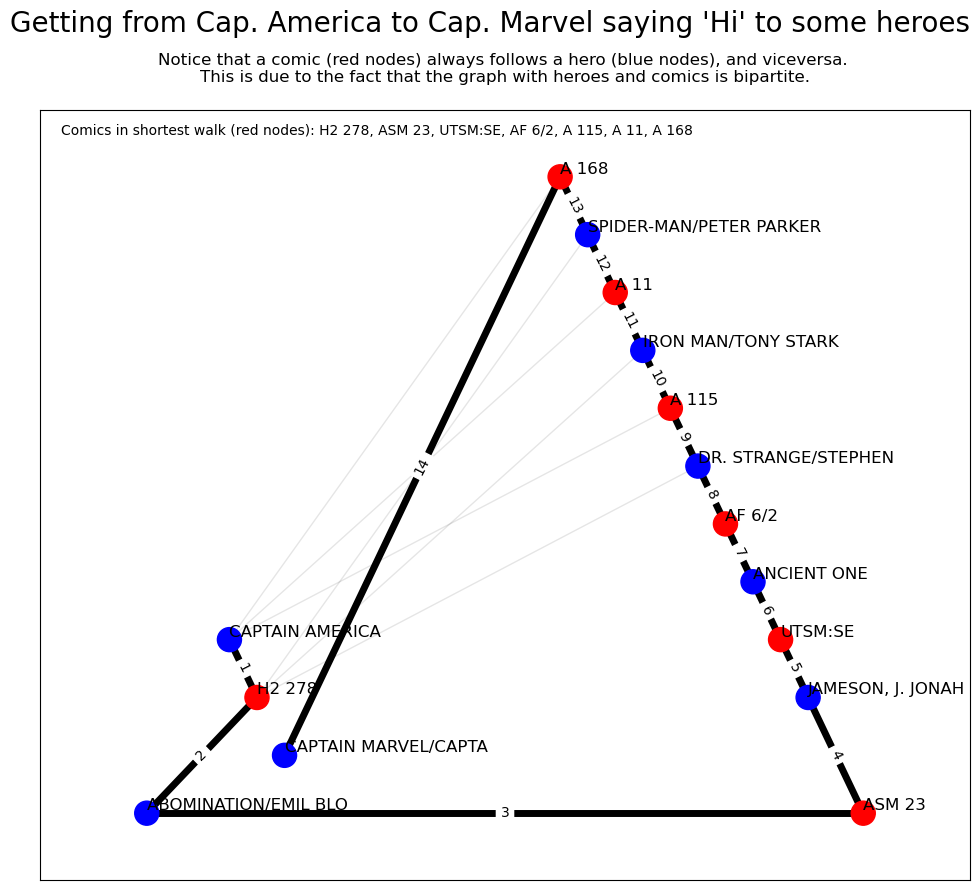

In [5]:
tuples_walk = list()
dict_labels_edge = dict()
for idx in range(len(shortest_walk)-1):  # Build list of edges in the walk and build dictionary of order indexes for edges
    tuples_walk.append((shortest_walk[idx], shortest_walk[idx+1]))
    dict_labels_edge[(shortest_walk[idx], shortest_walk[idx+1])] = idx+1

# Get subgraph to plot
plot_graph = nx.subgraph_view(hero_comics_graph, filter_node=lambda x: x in shortest_walk,
                              filter_edge = lambda x, y: (x, y) in tuples_walk or (y, x) in tuples_walk)
plt.gcf().set_size_inches((12, 10)) # Change size of the plot

dict_pos = nx.planar_layout(plot_graph) # Dictionary of positions
nx.draw_networkx_edges(plot_graph, pos = dict_pos, width=5)  # Draw edges in the walk

# Draw nodes with specific color, with labels (the names)
nx.draw_networkx_nodes(plot_graph, pos = dict_pos,
                       node_color = ['blue' if plot_graph.nodes[x]['type'] == 'hero' else 'red' for x in plot_graph.nodes])
nx.draw_networkx_labels(plot_graph, pos = dict_pos, horizontalalignment='left', verticalalignment='bottom')

# Draw edges with specific labels (the index highlighting the ordering)
nx.draw_networkx_edges(nx.subgraph_view(hero_comics_graph, filter_node=lambda x: x in shortest_walk),
                       pos = dict_pos, alpha = 0.1)
nx.draw_networkx_edge_labels(plot_graph, pos = dict_pos, edge_labels=dict_labels_edge, font_size=10)

plt.margins(x = 0.09)  # Add some margin in order not to cut labels
plt.text(-1.2, 0.45, s = 'Comics in shortest walk (red nodes): '+
                         ', '.join([x for x in shortest_walk if hero_comics_graph.nodes[x]['type'] == 'comic']))
plt.suptitle('Getting from Cap. America to Cap. Marvel saying \'Hi\' to some heroes', size = 20)
plt.title('Notice that a comic (red nodes) always follows a hero (blue nodes), and viceversa. \nThis is due to the fact that the graph with heroes and comics is bipartite.', pad = 20)

plt.show()

## Functionality 4: Explaining and Visualizing

In [6]:
num_edges_lost, edges_lost, cut_graph = controller.functionality(4, hero_graph, 35,
                                                                 hero_2='SPIDER-MAN/PETER PARKER', hero_1='IRON MAN/TONY STARK')

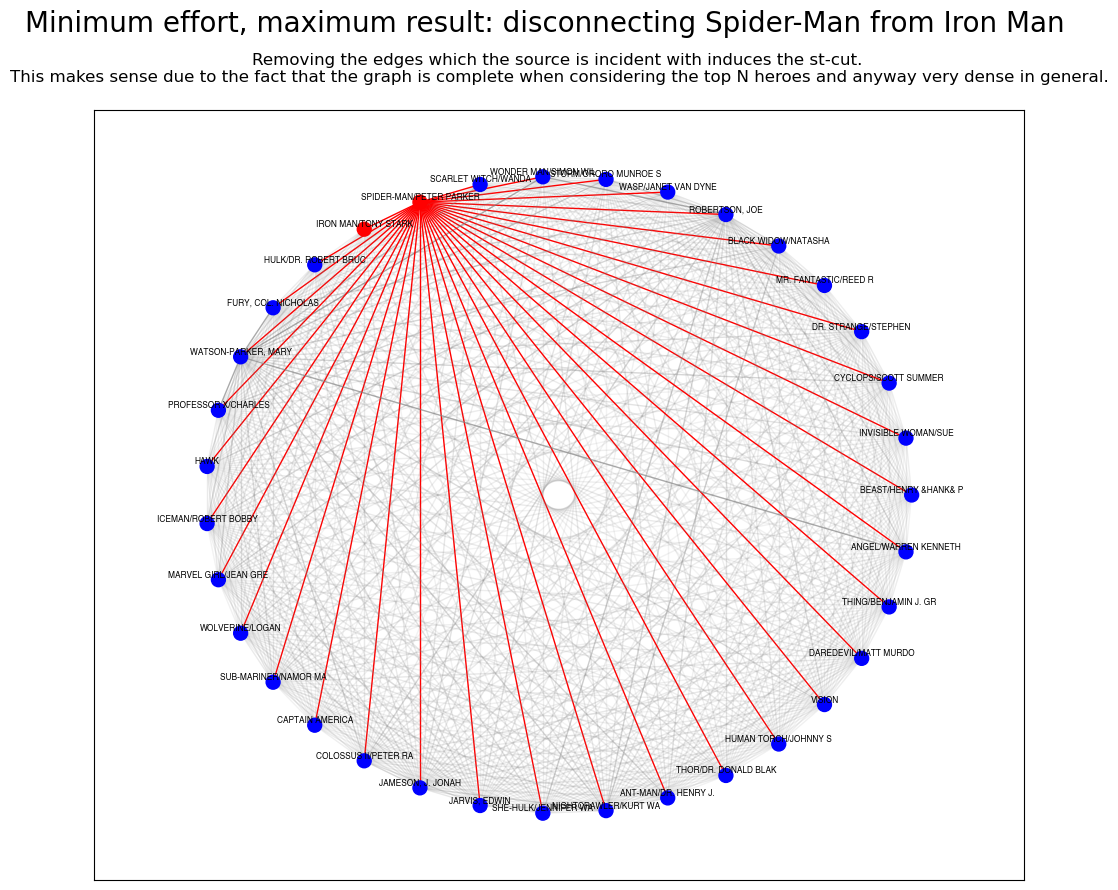

In [7]:
plt.gcf().set_size_inches((12, 10))
plot_graph = cut_graph.copy()
plot_graph.add_edges_from(edges_lost)

dict_pos = nx.circular_layout(plot_graph)
color_node = ['red' if node == 'SPIDER-MAN/PETER PARKER' or node == 'IRON MAN/TONY STARK' else 'blue' for node in plot_graph.nodes]
nx.draw_networkx_nodes(plot_graph, pos = dict_pos, node_size = 100, node_color=color_node)
nx.draw_networkx_labels(plot_graph, pos = dict_pos, font_size=6, font_family='helvetica', verticalalignment='bottom', font_weight='heavy')

color_edges = ['red' if (edge in edges_lost or tuple(reversed(edge)) in edges_lost) else 'gray' for edge in plot_graph.edges]
alpha_edges = [x[2]/1.5 if x[2] else 1 for x in plot_graph.edges(data='weight')]
nx.draw_networkx_edges(plot_graph, pos = dict_pos, alpha = alpha_edges, edge_color = color_edges)

plt.margins(x=0.10)
plt.suptitle('Minimum effort, maximum result: disconnecting Spider-Man from Iron Man', size = 20)
plt.title('Removing the edges which the source is incident with induces the st-cut. \nThis makes sense due to the fact that the graph is complete when considering'
          ' the top N heroes and anyway very dense in general.', pad = 20)
plt.show()